In [1]:
%matplotlib inline
import pandas as pd, seaborn as sns, numpy as np, os, matplotlib.pyplot as plt
import missingno as msno
from helper_funcs import *
import json, os
from tqdm import tqdm


if not 'df_' in globals(): 
    df = pd.read_parquet('data/involved_hebrew.parquet')
    df, val_map, imputed, cols = remove_hebrew_and_impute(df)

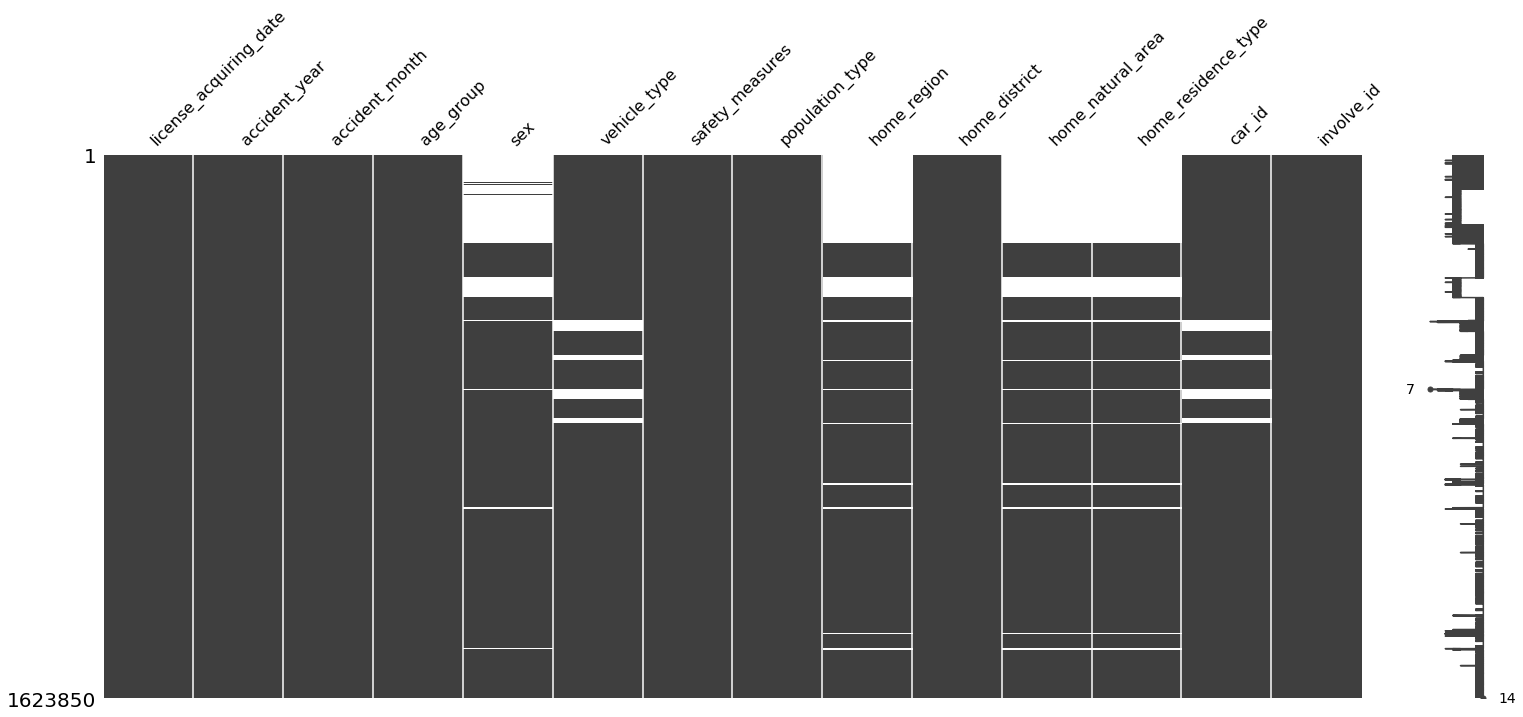

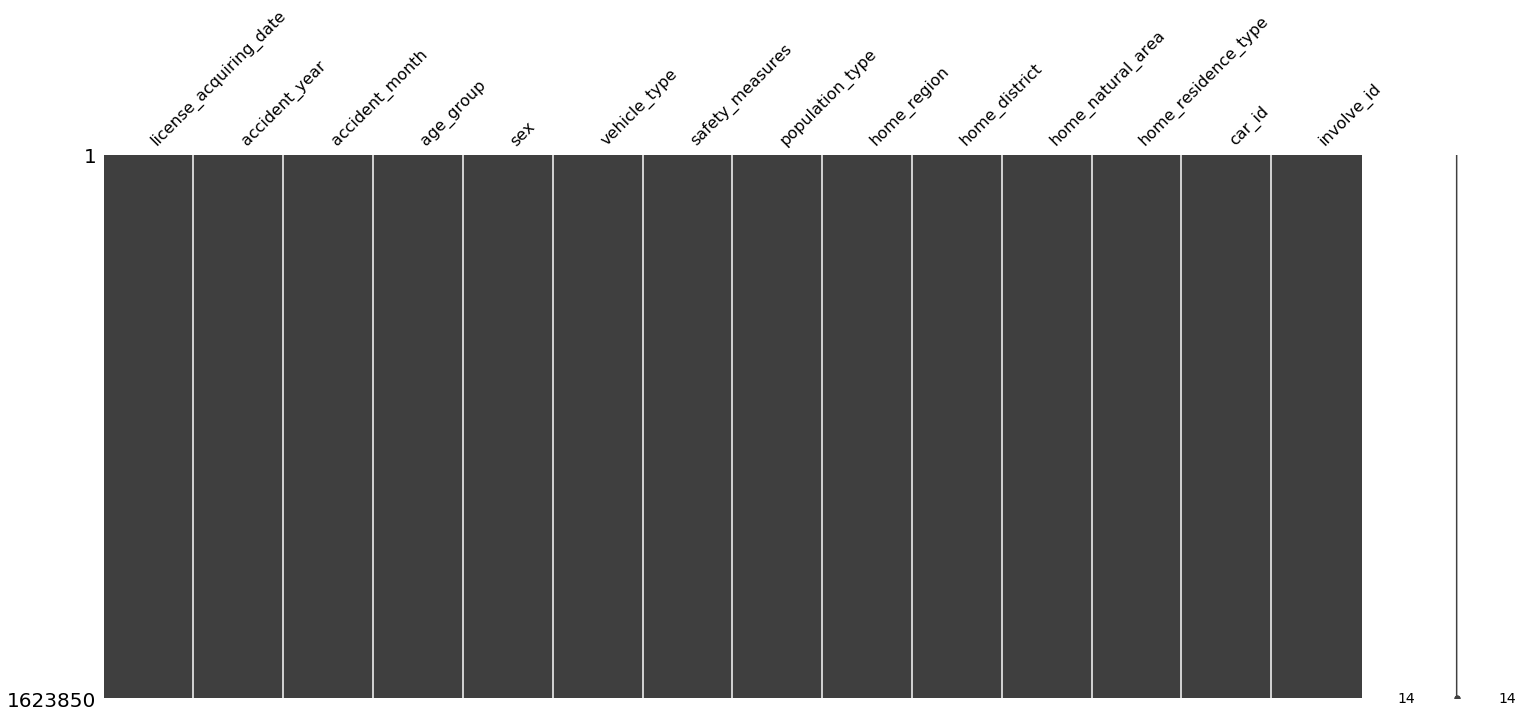

In [7]:
msno.matrix(df[cols])
msno.matrix(imputed[cols])

In [2]:
pd.get_dummies(df['injury_severity'], 'injury_severity', prefix_sep='=').head()

,injury_severity=1.0,injury_severity=2.0,injury_severity=3.0
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [3]:
df.late_deceased.value_counts()

1.0    3685
2.0     135
Name: late_deceased, dtype: int64

In [4]:
df.injury_severity.fillna(0).value_counts()

3.0    991981
0.0    608599
2.0     19585
1.0      3685
Name: injury_severity, dtype: int64

In [7]:
imputed.head(10)

,license_acquiring_date,accident_year,accident_month,age_group,sex,vehicle_type,safety_measures,population_type,home_region,home_district,home_natural_area,home_residence_type,car_id,involve_id
0,0.0,2009.0,4.0,99.0,1.0,1.0,5.0,1.0,3.0,99.0,336.0,17.0,1.0,4.0
1,0.0,2010.0,4.0,99.0,1.0,1.0,5.0,1.0,3.0,99.0,336.0,17.0,2.0,3.0
2,0.0,2010.0,11.0,99.0,1.0,3.0,5.0,1.0,3.0,99.0,336.0,17.0,1.0,4.0
3,0.0,2015.0,6.0,99.0,1.0,17.0,5.0,1.0,3.0,99.0,337.0,18.0,2.0,3.0
4,0.0,2015.0,10.0,99.0,1.0,1.0,5.0,1.0,3.0,99.0,337.0,18.0,2.0,1.0
5,0.0,2016.0,5.0,99.0,1.0,17.0,5.0,1.0,3.0,99.0,337.0,18.0,1.0,2.0
6,0.0,2014.0,10.0,99.0,1.0,17.0,5.0,1.0,3.0,99.0,337.0,18.0,1.0,2.0
7,0.0,2014.0,6.0,99.0,1.0,17.0,5.0,1.0,3.0,99.0,337.0,18.0,2.0,2.0
8,0.0,2009.0,12.0,99.0,1.0,17.0,5.0,1.0,3.0,99.0,336.0,17.0,2.0,2.0
9,0.0,2014.0,5.0,99.0,1.0,1.0,5.0,1.0,3.0,99.0,337.0,18.0,1.0,2.0


In [107]:
#prepare embedding features...

def map_categories(df):
    return {c: {v:i for i,v in enumerate(df[c].unique())} for c in df.columns}
cat = map_categories(imputed)
with open('data/embedding_num_cols.json', 'w') as f:
    json.dump(cat, f)
cat   

{'license_acquiring_date': {0.0: 0,
  1977.0: 1,
  1982.0: 2,
  2006.0: 3,
  2000.0: 4,
  1989.0: 5,
  1987.0: 6,
  2012.0: 7,
  2014.0: 8,
  1985.0: 9,
  2009.0: 10,
  1980.0: 11,
  2010.0: 12,
  2002.0: 13,
  2011.0: 14,
  1986.0: 15,
  1991.0: 16,
  2005.0: 17,
  1988.0: 18,
  1967.0: 19,
  1983.0: 20,
  2013.0: 21,
  1969.0: 22,
  1999.0: 23,
  1995.0: 24,
  2004.0: 25,
  1993.0: 26,
  1973.0: 27,
  1997.0: 28,
  2015.0: 29,
  2001.0: 30,
  2007.0: 31,
  1981.0: 32,
  2003.0: 33,
  1994.0: 34,
  1998.0: 35,
  1964.0: 36,
  2008.0: 37,
  1990.0: 38,
  1996.0: 39,
  1975.0: 40,
  1992.0: 41,
  1978.0: 42,
  1974.0: 43,
  1970.0: 44,
  1984.0: 45,
  1976.0: 46,
  1972.0: 47,
  1979.0: 48,
  1968.0: 49,
  1965.0: 50,
  1971.0: 51,
  1966.0: 52,
  2017.0: 53,
  2016.0: 54,
  1963.0: 55,
  2018.0: 56,
  1962.0: 57,
  1957.0: 58,
  1961.0: 59,
  1959.0: 60,
  1956.0: 61,
  1951.0: 62,
  1958.0: 63,
  1955.0: 64,
  1953.0: 65,
  1960.0: 66,
  1952.0: 67,
  1949.0: 68,
  1950.0: 69,
  1954.

# Build an embedding neural network to learn to latent features of the categorical data?

In [152]:
from keras.layers import Embedding, Dense, Input, concatenate, Reshape
from keras.models import Model

def build_emb_head(df = imputed, min_emb_size = 2, max_emb_size= 15):
    '''create a concatenated inputs of embedding layers'''
    embs = []
    inps = []
    for c in df.columns:
        u = df[c].nunique()
        n_embedding = min([int(u/2), max_emb_size])
        n_embedding = max([max_emb_size, min_emb_size])
        inp = Input(shape = (1,),  name=f'inp_{c}')
        e = Embedding(u, n_embedding, name=f'emb_{c}')(inp)
        
        embs.append(e)
        inps.append(inp)
        
    embs =  concatenate(embs)
    embs = Reshape(( int(embs.shape[-1]) ,))(embs)
    return embs, inps

def build_model( df = imputed, 
                  layers = [200, 200, 200], 
                  last_size=3, 
                  last_activation = 'softmax',
                  last_optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'],
                  min_emb_size = 2, 
                  max_emb_size= 15):
    embs, inps = build_emb_head(df, min_emb_size, max_emb_size)
    x = embs
    for l in layers:
        x = Dense(l, activation='relu')(x)
    
    x = Dense(last_size, activation = last_activation)(x)
    
    model = Model(inputs=inps, outputs=x)
    model.compile(optimizer=last_optimizer, loss=loss, metrics=metrics)
    return model
        

model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_license_acquiring_date (Inp (None, 1)            0                                            
__________________________________________________________________________________________________
inp_accident_year (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
inp_accident_month (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
inp_age_group (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
inp_sex (I

In [128]:
y = pd.get_dummies(df['injury_severity'], 'injury_severity', prefix_sep='=').values
y

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [149]:
if not 'X' in globals():
    X = imputed.copy()
    for c in tqdm(X.columns):
        X[c] = X[c].apply(cat[c].get)

x = [X[c].values for c in X.columns]

In [150]:
y.shape, x[0].shape

((1623850, 3), (1623850,))

In [153]:
model.fit(x,y)

Epoch 1/1
1623850/1623850 [==============================] - 225s 139us/step - loss: 0.0699 - acc: 0.6109
